In [1]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import warnings
warnings.filterwarnings('ignore') # 경고 무시

In [2]:
'''
데이터 불러오기
'''
original_data_df = pd.read_csv('./data/Champagne_Sales.csv', header = 0, parse_dates = [0], index_col = 0, squeeze = True)
print(original_data_df.shape)
print(original_data_df)

(105,)
Month
1964-01-01    2815
1964-02-01    2672
1964-03-01    2755
1964-04-01    2721
1964-05-01    2946
              ... 
1972-05-01    4618
1972-06-01    5312
1972-07-01    4298
1972-08-01    1413
1972-09-01    5877
Name: Champagne sales, Length: 105, dtype: int64


In [3]:
'''
데이터프레임 컬럼 이름 변경
'''
original_data_df.columns = ['Month', 'Sales']
print(original_data_df.head())

Month
1964-01-01    2815
1964-02-01    2672
1964-03-01    2755
1964-04-01    2721
1964-05-01    2946
Name: Champagne sales, dtype: int64


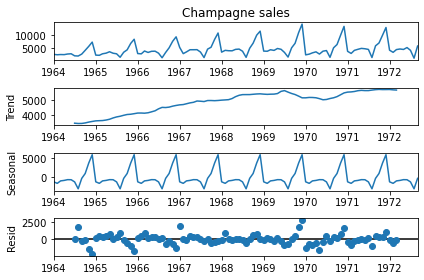

In [4]:
'''
statsmodels.tsa.seasonal - seasonal_decompose 분석 (trend, seasonal, resid)
'''
result = seasonal_decompose(original_data_df, model = 'additive')
re_plot = result.plot()
plt.show()

In [5]:
result_df = pd.DataFrame(
    {
        'Observed': result.observed, 
        'Trend': result.trend, 
        'Seasonal': result.seasonal, 
        'Resid': result.resid
    }
)
result_df.reset_index(level = 0, inplace = True)
result_df.dropna(axis = 0, inplace = True)
result_df.reset_index(drop = True, inplace = True)

In [6]:
result_df.head()

,Month,Observed,Trend,Seasonal,Resid
0,1964-07-01,2282.0,3466.750000,-1242.500124,57.750124
1,1964-08-01,2212.0,3447.125000,-3060.505332,1825.380332
2,1964-09-01,2922.0,3450.416667,-312.390749,-216.025918
3,1964-10-01,4301.0,3484.625000,965.729043,-149.354043
4,1964-11-01,5764.0,3541.916667,3730.130084,-1508.046751


In [7]:
'''
data 연관성 확인
'''
print(result_df['Trend'][0] + result_df['Seasonal'][0] + result_df['Resid'][0])
print(result_df['Trend'][1] + result_df['Seasonal'][1] + result_df['Resid'][1])
print(result_df['Trend'][89] + result_df['Seasonal'][89] + result_df['Resid'][89])

2282.0
2212.0
12670.0


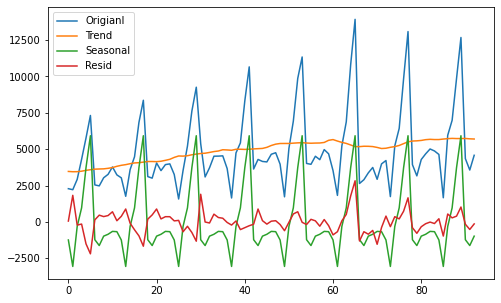

In [8]:
'''
decomposed data 시각화
'''
plt.figure(figsize = (8, 5))
plt.plot(result_df['Observed'], label = 'Origianl')
plt.plot(result_df['Trend'], label = 'Trend')
plt.plot(result_df['Seasonal'], label = 'Seasonal')
plt.plot(result_df['Resid'], label = 'Resid')
plt.legend(loc = 'upper left')
plt.show()

In [9]:
'''
날짜 하이픈 제거
'''
result_df['Month'] = result_df['Month'].astype(str)
result_df['Month'] = result_df['Month'].str.replace(pat=r'[^\w\s]', repl=r'', regex=True) # 하이픈제거
result_df = result_df.astype('int')

In [10]:
print(result_df[50:80])

       Month  Observed  Trend  Seasonal  Resid
50  19680901      5048   5389      -312    -29
51  19681001      6922   5410       965    545
52  19681101      9858   5430      3730    697
53  19681201     11331   5440      5919    -29
54  19690101      4016   5419     -1223   -179
55  19690201      3957   5404     -1624    176
56  19690301      4510   5416      -979     73
57  19690401      4276   5421      -850   -295
58  19690501      4968   5458      -652    161
59  19690601      4677   5605      -671   -257
60  19690701      3523   5656     -1242   -890
61  19690801      1821   5554     -3060   -673
62  19690901      5222   5463      -312     71
63  19691001      6872   5393       965    513
64  19691101     10803   5285      3730   1787
65  19691201     13916   5171      5919   2824
66  19700101      2639   5172     -1223  -1309
67  19700201      2899   5197     -1624   -674
68  19700301      3370   5194      -979   -844
69  19700401      3740   5175      -850   -585
70  19700501 

In [11]:
'''
스케일링
'''
max_abs_scaler = MaxAbsScaler()
scaled_result_np = max_abs_scaler.fit_transform(result_df)

In [12]:
'''
데이터프레임 재생성
'''
scaled_result_df = pd.DataFrame(scaled_result_np)
scaled_result_df.columns = ['Month', 'Observed', 'Trend', 'Seasonal', 'Resid']

In [13]:
print(scaled_result_df.head())

      Month  Observed     Trend  Seasonal     Resid
0  0.995964  0.163984  0.604149 -0.209833  0.020184
1  0.995969  0.158954  0.600837 -0.516979  0.646246
2  0.995974  0.209974  0.601360 -0.052712 -0.076487
3  0.995979  0.309069  0.607286  0.163034 -0.052762
4  0.995984  0.414199  0.617222  0.630174 -0.533994


In [14]:
'''
train, test data 분리
'''
train_size = int(len(scaled_result_df) * 0.7)
train_data_df = scaled_result_df[0:train_size].reset_index(drop = True)
test_data_df = scaled_result_df[train_size:].reset_index(drop = True)

In [15]:
print(train_data_df.head())
print(test_data_df.head())

      Month  Observed     Trend  Seasonal     Resid
0  0.995964  0.163984  0.604149 -0.209833  0.020184
1  0.995969  0.158954  0.600837 -0.516979  0.646246
2  0.995974  0.209974  0.601360 -0.052712 -0.076487
3  0.995979  0.309069  0.607286  0.163034 -0.052762
4  0.995984  0.414199  0.617222  0.630174 -0.533994
      Month  Observed     Trend  Seasonal     Resid
0  0.998524  1.000000  0.901342  1.000000  1.000000
1  0.998976  0.189638  0.901516 -0.206623 -0.463527
2  0.998981  0.208321  0.905874 -0.274371 -0.238669
3  0.998986  0.242167  0.905351 -0.165400 -0.298867
4  0.998991  0.268755  0.902039 -0.143605 -0.207153


In [16]:
'''
data size 확인
'''
print("train size", train_size)
print("train shape:", train_data_df.shape)
print("test shape:", test_data_df.shape)

train size 65
train shape: (65, 5)
test shape: (28, 5)


In [17]:
'''
input, label data 분리
'''
x_train_data_df = train_data_df[['Month', 'Trend', 'Seasonal', 'Resid']]
y_train_data_df = train_data_df[['Trend', 'Seasonal', 'Resid']]

x_test_data_df = test_data_df[['Month', 'Trend', 'Seasonal', 'Resid']]
y_test_data_df = test_data_df[['Trend', 'Seasonal', 'Resid']]

<AxesSubplot:>

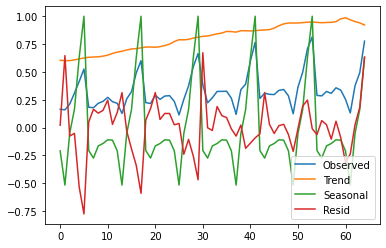

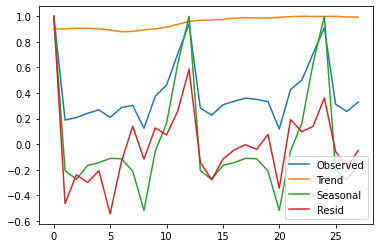

In [18]:
'''
scaled data 시각화
'''
train_data_df.drop('Month', axis = 1).plot()
test_data_df.drop('Month', axis = 1).plot()

In [19]:
print("x train shape", x_train_data_df.shape)
print("y train shape", y_train_data_df.shape)
print("x test shape", x_test_data_df.shape)
print("y test shape", y_test_data_df.shape)

x train shape (65, 4)
y train shape (65, 3)
x test shape (28, 4)
y test shape (28, 3)


In [20]:
'''
랜덤시드 고정
'''
torch.manual_seed(777)

In [21]:
'''
GPU 사용
'''
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [22]:
'''
하이퍼파라미터

입력 형태: (Batch size, sequence_length, input_dimension)
'''
batch_size = 6 # 반년주기
sequence_length = 1
input_size = 4 # 1개의 sequence의 내부에 4개의 데이터
hidden_size = 32
output_size = 3 # Trend, Seasonal, Residual
num_layers = 3
learning_rate = 1e-3
nb_epochs = 500

In [23]:
'''
데이터셋함수
'''
def MakeDataSet(x_data_df, y_data_df):
    x_ts = torch.FloatTensor(np.array(x_data_df))
    y_ts = torch.FloatTensor(np.array(y_data_df))
    dataset_ts = TensorDataset(x_ts, y_ts)

    return dataset_ts

'''
데이터로더
'''
def MakeDataLoader(dataset, batch_size):
    dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = True)

    return dataloader

In [24]:
'''
데이터셋
'''
train_dataset_ts = MakeDataSet(x_train_data_df, y_train_data_df)
test_dataset_ts = MakeDataSet(x_test_data_df, y_test_data_df)

'''
데이터로더
'''
train_dataloader = MakeDataLoader(train_dataset_ts, batch_size)
test_dataloader = MakeDataLoader(test_dataset_ts, batch_size)

In [25]:
'''
사용할 데이터 확인
'''
for i, samples in enumerate(test_dataloader):
    x, y = samples
    print("Batch", i + 1)
    print("Input",x.shape)
    print("Target",y.shape)

Batch 1
Input torch.Size([6, 4])
Target torch.Size([6, 3])
Batch 2
Input torch.Size([6, 4])
Target torch.Size([6, 3])
Batch 3
Input torch.Size([6, 4])
Target torch.Size([6, 3])
Batch 4
Input torch.Size([6, 4])
Target torch.Size([6, 3])
Batch 5
Input torch.Size([4, 4])
Target torch.Size([4, 3])


In [26]:
'''
model 설계
'''
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(Net, self).__init__()
        self.rnn = nn.LSTM(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = num_layers,
            batch_first = True
        )
        self.fc = nn.Linear(
            hidden_size,
            output_size,
            bias = True
        )

    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.fc(x[:, -1])
        return x

In [27]:
'''
model, cost, optimizer
'''
model = Net(input_size, hidden_size, output_size, num_layers).to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [28]:
'''
learning test
'''
x, y = list(train_dataloader)[0]
x = x.view(-1, sequence_length, input_size).to(device) # RNN input: batch size, sequence length, input size
y = y.to(device)
print("X shape: ", x, x.shape)
print("Y shape: ", y.shape)
print()
print("Model: ", model(x))
print()
print("Loss: ", criterion(model(x), y))

X shape:  tensor([[[ 0.9975,  0.8696, -0.0527,  0.0220]],

        [[ 0.9985,  0.9449, -0.1436, -0.1045]],

        [[ 0.9970,  0.7263, -0.1436,  0.0726]],

        [[ 0.9985,  0.9681, -0.5170, -0.2383]],

        [[ 0.9985,  0.9212,  0.6302,  0.6328]],

        [[ 0.9975,  0.8705,  1.0000, -0.0931]]], device='cuda:0') torch.Size([6, 1, 4])
Y shape:  torch.Size([6, 3])

Model:  tensor([[ 0.0355,  0.0787, -0.1788],
        [ 0.0356,  0.0787, -0.1788],
        [ 0.0356,  0.0786, -0.1788],
        [ 0.0358,  0.0786, -0.1788],
        [ 0.0350,  0.0791, -0.1788],
        [ 0.0351,  0.0792, -0.1787]], device='cuda:0', grad_fn=<AddmmBackward>)

Loss:  tensor(0.3752, device='cuda:0', grad_fn=<MseLossBackward>)


In [29]:
for i, samples in enumerate(train_dataloader):
    x, y = samples
    print(i+ 1)
    x = x.view(-1, sequence_length, input_size).to(device)
    y = y.to(device)
    print(x)

1
tensor([[[ 0.9985,  0.9212,  0.6302,  0.6328]],

        [[ 0.9970,  0.7924,  0.1630, -0.1066]],

        [[ 0.9970,  0.7894, -0.5170,  0.0365]],

        [[ 0.9980,  0.9388, -0.2098, -0.0634]],

        [[ 0.9964,  0.6315, -0.2066,  0.0496]],

        [[ 0.9965,  0.7159,  1.0000, -0.5914]]], device='cuda:0')
2
tensor([[[ 0.9975,  0.8576, -0.5170, -0.0768]],

        [[ 0.9970,  0.7215, -0.1654,  0.3137]],

        [[ 0.9975,  0.8318, -0.1654, -0.0266]],

        [[ 0.9980,  0.8797, -0.1654,  0.0301]],

        [[ 0.9965,  0.7091,  0.6302, -0.3403]],

        [[ 0.9970,  0.7263, -0.1436,  0.0726]]], device='cuda:0')
3
tensor([[[ 0.9985,  0.9400,  0.1630,  0.1817]],

        [[ 0.9975,  0.8191, -0.2066,  0.6721]],

        [[ 0.9965,  0.6353, -0.1654,  0.1292]],

        [[ 0.9960,  0.6008, -0.5170,  0.6462]],

        [[ 0.9980,  0.9482,  1.0000, -0.0103]],

        [[ 0.9964,  0.6336, -0.2744,  0.1640]]], device='cuda:0')
4
tensor([[[ 0.9980,  0.8742, -0.2066, -0.0563]],

        [[

In [30]:
'''
학습
'''
losses = []
for epoch in range(nb_epochs):
    train_loss = 0.0
    for i, samples in enumerate(train_dataloader):
        x_train, y_train = samples
        x_train = x_train.view(-1, sequence_length, input_size).to(device)
        y_train = y_train.to(device)
        
        hypothesis = model(x_train)
        optimizer.zero_grad()
        loss = criterion(hypothesis, y_train)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        losses.append(loss.item())

    print("Epoch: {} |  | Loss: {:.6f}".format(epoch + 1, loss.item()))

torch.save(model, './data/model.pt')

Epoch: 1 |  | Loss: 0.306803
Epoch: 2 |  | Loss: 0.265000
Epoch: 3 |  | Loss: 0.226261
Epoch: 4 |  | Loss: 0.265865
Epoch: 5 |  | Loss: 0.148308
Epoch: 6 |  | Loss: 0.056320
Epoch: 7 |  | Loss: 0.093820
Epoch: 8 |  | Loss: 0.080274
Epoch: 9 |  | Loss: 0.018205
Epoch: 10 |  | Loss: 0.122571
Epoch: 11 |  | Loss: 0.059909
Epoch: 12 |  | Loss: 0.135891
Epoch: 13 |  | Loss: 0.099428
Epoch: 14 |  | Loss: 0.047782
Epoch: 15 |  | Loss: 0.076739
Epoch: 16 |  | Loss: 0.025896
Epoch: 17 |  | Loss: 0.094661
Epoch: 18 |  | Loss: 0.097601
Epoch: 19 |  | Loss: 0.062976
Epoch: 20 |  | Loss: 0.069457
Epoch: 21 |  | Loss: 0.134761
Epoch: 22 |  | Loss: 0.074858
Epoch: 23 |  | Loss: 0.028880
Epoch: 24 |  | Loss: 0.009941
Epoch: 25 |  | Loss: 0.008367
Epoch: 26 |  | Loss: 0.019783
Epoch: 27 |  | Loss: 0.023482
Epoch: 28 |  | Loss: 0.036889
Epoch: 29 |  | Loss: 0.035178
Epoch: 30 |  | Loss: 0.053658
Epoch: 31 |  | Loss: 0.018847
Epoch: 32 |  | Loss: 0.017297
Epoch: 33 |  | Loss: 0.036205
Epoch: 34 |  | Loss

Epoch: 272 |  | Loss: 0.000155
Epoch: 273 |  | Loss: 0.000223
Epoch: 274 |  | Loss: 0.000194
Epoch: 275 |  | Loss: 0.000180
Epoch: 276 |  | Loss: 0.000077
Epoch: 277 |  | Loss: 0.000192
Epoch: 278 |  | Loss: 0.000066
Epoch: 279 |  | Loss: 0.000169
Epoch: 280 |  | Loss: 0.000098
Epoch: 281 |  | Loss: 0.000391
Epoch: 282 |  | Loss: 0.000125
Epoch: 283 |  | Loss: 0.000181
Epoch: 284 |  | Loss: 0.000211
Epoch: 285 |  | Loss: 0.000056
Epoch: 286 |  | Loss: 0.000243
Epoch: 287 |  | Loss: 0.000157
Epoch: 288 |  | Loss: 0.000094
Epoch: 289 |  | Loss: 0.000025
Epoch: 290 |  | Loss: 0.000077
Epoch: 291 |  | Loss: 0.000281
Epoch: 292 |  | Loss: 0.000358
Epoch: 293 |  | Loss: 0.000115
Epoch: 294 |  | Loss: 0.000103
Epoch: 295 |  | Loss: 0.000100
Epoch: 296 |  | Loss: 0.000163
Epoch: 297 |  | Loss: 0.000168
Epoch: 298 |  | Loss: 0.000147
Epoch: 299 |  | Loss: 0.000164
Epoch: 300 |  | Loss: 0.000105
Epoch: 301 |  | Loss: 0.000092
Epoch: 302 |  | Loss: 0.000155
Epoch: 303 |  | Loss: 0.000198
Epoch: 3

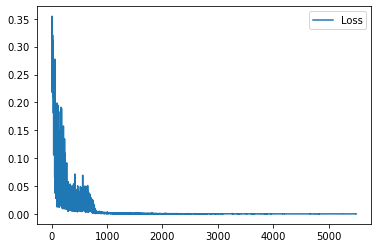

In [31]:
plt.plot(losses, label = 'Loss')
plt.legend(loc = 'upper right')
plt.show()

In [32]:
'''
평가
'''
with torch.no_grad():
    predicted_data_list = []
    label_list = []
    for i, samples in enumerate(test_dataloader):
        x_test, y_test = samples
        x_test = x_test.view(-1, sequence_length, input_size).to(device)
        y_test = y_test.to(device)
        
        prediction = model(x_test)
        predicted_data_list.append(prediction.tolist())
        label_list.append(y_test.tolist())#.cpu().data.numpy())
        loss = criterion(prediction, y_test)
        
predicted_data_np = np.array(sum(sum(predicted_data_list, []), []))
label_np = np.array(sum(sum(label_list, []), []))

In [33]:
'''
데이터 비교
'''
label_df = pd.DataFrame(label_np.reshape(-1, 3))
label_df.columns = ['Original Trend', 'Original Seasonal', 'Original Resid']
predicted_data_df = pd.DataFrame(predicted_data_np.reshape(-1, 3))
predicted_data_df.columns = ['Predicted Trend', 'Predicted Seasonal', 'Predicted Resid']

In [34]:
print(label_df.head())
print(predicted_data_df.head())

   Original Trend  Original Seasonal  Original Resid
0        1.000000           0.163034        0.098088
1        0.968276          -0.206623       -0.140935
2        0.905351          -0.165400       -0.298867
3        0.905874          -0.274371       -0.238669
4        0.984835          -0.143605       -0.043909
   Predicted Trend  Predicted Seasonal  Predicted Resid
0         1.002032            0.154300         0.116944
1         0.969589           -0.229903        -0.130887
2         0.904438           -0.185022        -0.275541
3         0.906495           -0.292560        -0.221979
4         0.987192           -0.164635        -0.036417


In [35]:
'''
결과 데이터 데이터프레임 생성
'''
sum_label_data_df = pd.DataFrame({'Original Observed': label_df.sum(axis = 1)})
sum_predicted_data_df = pd.DataFrame({'Predicted Observed': predicted_data_df.sum(axis = 1)})

In [36]:
'''
결과 데이터 데이터프레임 결합
'''
test_result_df = pd.concat([x_test_data_df['Month'], sum_predicted_data_df['Predicted Observed'], predicted_data_df ], axis = 1)

In [37]:
test_result_df.head()

,Month,Predicted Observed,Predicted Trend,Predicted Seasonal,Predicted Resid
0,0.998524,1.273275,1.002032,0.154300,0.116944
1,0.998976,0.608799,0.969589,-0.229903,-0.130887
2,0.998981,0.443875,0.904438,-0.185022,-0.275541
3,0.998986,0.391957,0.906495,-0.292560,-0.221979
4,0.998991,0.786141,0.987192,-0.164635,-0.036417


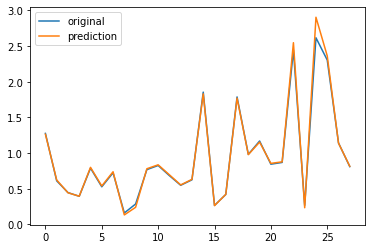

In [38]:
'''
결과 데이터 시각화
'''
plt.plot(sum_predicted_data_df)
plt.plot(sum_label_data_df)
plt.legend(['original', 'prediction'])
plt.show()

In [39]:
inversed_sum_predicted_data_np = max_abs_scaler.inverse_transform(test_result_df)
inversed_sum_predicted_data_df = pd.DataFrame(inversed_sum_predicted_data_np)

In [40]:
inversed_test_data_np = max_abs_scaler.inverse_transform(test_data_df)
inversed_test_data_df = pd.DataFrame(inversed_test_data_np)

In [41]:
inversed_test_data_df.columns = [
    'Original Month', 
    'Original Observed', 
    'Original Trend', 
    'Original Seasonal', 
    'Original Resid'
]

inversed_sum_predicted_data_df.columns = [
    'Predicted Month', 
    'Predicted Observed', 
    'Predicted Trend', 
    'Predicted Seasonal', 
    'Predicted Resid'
]

In [47]:
inversed_test_data_df = inversed_test_data_df.round(0).astype(int)
inversed_test_data_df['Original Month'] = inversed_test_data_df['Original Month'].astype(str)

inversed_sum_predicted_data_df = inversed_sum_predicted_data_df.round(0).astype(int)
inversed_sum_predicted_data_df['Predicted Month'] = inversed_sum_predicted_data_df['Predicted Month'].astype(str)

In [48]:
inversed_test_data_df.head()

,Original Month,Original Observed,Original Trend,Original Seasonal,Original Resid
0,19691201,13916,5171,5919,2824
1,19700101,2639,5172,-1223,-1309
2,19700201,2899,5197,-1624,-674
3,19700301,3370,5194,-979,-844
4,19700401,3740,5175,-850,-585


In [49]:
inversed_sum_predicted_data_df.head()

,Predicted Month,Predicted Observed,Predicted Trend,Predicted Seasonal,Predicted Resid
0,19691201,17719,5749,913,330
1,19700101,8472,5563,-1361,-370
2,19700201,6177,5189,-1095,-778
3,19700301,5454,5201,-1732,-627
4,19700401,10940,5664,-974,-103


In [ ]:
plt.plot(inversed_sum_predicted_data_df['Predicted Month'], inversed_sum_predicted_data_df['Predicted Observed'], label = 'Prediction')
plt.plot(inversed_test_data_df['Original Month'], inversed_test_data_df['Original Observed'], label = 'Original')
plt.legend(loc = 'upper left')
plt.plot()

# 

In [ ]:
inversed_test_data_df['Original Month'] = pd.to_datetime(inversed_test_data_df['Original Month'])
inversed_sum_predicted_data_df['Predicted Month'] = pd.to_datetime(inversed_sum_predicted_data_df['Predicted Month'])

In [ ]:
'''
Observed data만 별도로 invers한 경우

Original Observed data의 scaling이 다르게 되었기 때문에 기존 scaled data와 결과값이 다르게 나옴
'''
observed_data_min_max_scaler = MaxAbsScaler()
scaled_observed_data_np = observed_data_min_max_scaler.fit_transform(np.array(result_df['Observed']).reshape(-1, 1))
test_label_df = pd.DataFrame(scaled_observed_data_np)
test_label_df = test_label_df[train_size:].reset_index(drop = True)

In [ ]:
inversed_test_data_np = observed_data_min_max_scaler.inverse_transform(sum_label_data_df)
inversed_test_data_df = pd.DataFrame(inversed_test_data_np)
inversed_test_data_df = inversed_test_data_df.round(0).astype(int)
inversed_test_data_df.columns = ['Original Observed']

In [ ]:
inversed_sum_predicted_data_np = observed_data_min_max_scaler.inverse_transform(sum_predicted_data_df)
inversed_sum_predicted_data_df = pd.DataFrame(inversed_sum_predicted_data_np)
inversed_sum_predicted_data_df = inversed_sum_predicted_data_df.round(0).astype(int)
inversed_sum_predicted_data_df.columns = ['Predicted Observed']

In [ ]:
inversed_test_data_df.head()

In [ ]:
inversed_sum_predicted_data_df.head()

In [ ]:
plt.plot(inversed_test_data_df, label = 'original')
plt.plot(inversed_sum_predicted_data_df, label = 'predicted')
plt.legend('upper right')
plt.show()